<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week7/DeepRNN/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import time

## ====== 1. SETUP DAN PERSIAPAN DATA ======


In [4]:
# Mengatur seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [5]:
# Konfigurasi awal
max_features = 20000  # Ukuran vocabulary
maxlen = 200  # Panjang maksimum sequence
batch_size = 32
target_accuracy = 0.90  # Target akurasi 90%
max_epochs = 10  # Maksimum 10 epoch

In [6]:
print("Loading data...")
# Load dataset IMDB
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(f"Training data: {len(x_train)}, Testing data: {len(x_test)}")

Loading data...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data: 25000, Testing data: 25000


In [7]:
# Padding sequences
print("Padding sequences...")
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Padding sequences...


In [8]:
# Memisahkan validation set
val_split = int(len(x_train) * 0.2)
x_val = x_train[:val_split]
y_val = y_train[:val_split]
x_train = x_train[val_split:]
y_train = y_train[val_split:]

print(f"Training shape: {x_train.shape}")
print(f"Validation shape: {x_val.shape}")
print(f"Testing shape: {x_test.shape}")

Training shape: (20000, 200)
Validation shape: (5000, 200)
Testing shape: (25000, 200)


## ====== 2. DEFINISI MODEL DEEP RNN ======


In [9]:
def build_deep_rnn_model(hp=None):
    model = Sequential()

    # Layer embedding
    embedding_dim = 128 if hp is None else hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))

    # Layer RNN pertama
    lstm_units1 = 64 if hp is None else hp.Int('lstm_units1', min_value=32, max_value=128, step=32)
    dropout_rate1 = 0.3 if hp is None else hp.Float('dropout_rate1', min_value=0.2, max_value=0.5, step=0.1)

    model.add(LSTM(lstm_units1, return_sequences=True))
    model.add(Dropout(dropout_rate1))

    # Layer RNN kedua
    lstm_units2 = 64 if hp is None else hp.Int('lstm_units2', min_value=32, max_value=128, step=32)
    dropout_rate2 = 0.3 if hp is None else hp.Float('dropout_rate2', min_value=0.2, max_value=0.5, step=0.1)

    model.add(LSTM(lstm_units2, return_sequences=True))
    model.add(Dropout(dropout_rate2))

    # Layer RNN ketiga
    lstm_units3 = 64 if hp is None else hp.Int('lstm_units3', min_value=32, max_value=128, step=32)
    dropout_rate3 = 0.3 if hp is None else hp.Float('dropout_rate3', min_value=0.2, max_value=0.5, step=0.1)

    model.add(LSTM(lstm_units3))
    model.add(Dropout(dropout_rate3))

    # Layer output
    model.add(Dense(1, activation='sigmoid'))

    # Kompilasi model
    learning_rate = 0.001 if hp is None else hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


## ====== 3. VISUALISASI HASIL ======


In [11]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [12]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [13]:
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc


## ====== 4. EVALUASI MODEL ======


In [14]:
def evaluate_model(model, x_test, y_test):
    y_pred_prob = model.predict(x_test, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # F1-squared metric (penyesuaian dari F1 score)
    f1_squared = f1 ** 2

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    # Plot ROC curve dan hitung AUC
    roc_auc = plot_roc_curve(y_test, y_pred_prob)

    # Menampilkan hasil evaluasi
    print("\n===== Model Evaluation =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F1-Squared: {f1_squared:.4f}")
    print(f"AUC: {roc_auc:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_squared': f1_squared,
        'auc': roc_auc
    }


## ====== 5. HYPERPARAMETER TUNING ======

In [15]:
def hyperparameter_tuning():
    # Custom callback untuk berhenti jika akurasi mencapai target
    class TargetAccuracyStop(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('val_accuracy') >= target_accuracy:
                print(f"\nAkurasi {target_accuracy*100}% tercapai, menghentikan training!")
                self.model.stop_training = True

    # Menggunakan RandomSearch dengan jumlah trial terbatas untuk mempercepat proses
    tuner = kt.RandomSearch(
        build_deep_rnn_model,
        objective='val_accuracy',
        max_trials=5,  # Hanya 5 trial untuk mempercepat proses
        executions_per_trial=1,
        directory='keras_tuner',
        project_name='imdb_deep_rnn'
    )

    # Callbacks untuk hyperparameter tuning
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    target_stop = TargetAccuracyStop()

    # Melakukan hyperparameter search
    print("\n===== Starting Hyperparameter Tuning (Max 5 Trials) =====")
    tuner.search(
        x_train, y_train,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[stop_early, target_stop]
    )

    # Mendapatkan model terbaik
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\n===== Best Hyperparameters =====")
    print(f"Embedding dimension: {best_hps.get('embedding_dim')}")
    print(f"LSTM units 1: {best_hps.get('lstm_units1')}")
    print(f"Dropout rate 1: {best_hps.get('dropout_rate1')}")
    print(f"LSTM units 2: {best_hps.get('lstm_units2')}")
    print(f"Dropout rate 2: {best_hps.get('dropout_rate2')}")
    print(f"LSTM units 3: {best_hps.get('lstm_units3')}")
    print(f"Dropout rate 3: {best_hps.get('dropout_rate3')}")
    print(f"Learning rate: {best_hps.get('learning_rate')}")

    # Membuat model dengan hyperparameter terbaik
    best_model = tuner.hypermodel.build(best_hps)
    return best_model, best_hps

## ====== 6. TRAINING MODEL ======

In [16]:
def train_final_model(model):
    print("\n===== Training Final Model =====")

    # Custom callback untuk berhenti jika akurasi mencapai target
    class TargetAccuracyStop(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('val_accuracy') >= target_accuracy:
                print(f"\nAkurasi {target_accuracy*100}% tercapai, menghentikan training!")
                self.model.stop_training = True

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        'best_deep_rnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    target_stop = TargetAccuracyStop()

    start_time = time.time()

    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=max_epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, checkpoint, target_stop],
        verbose=1
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Visualisasi history training
    plot_history(history)

    return history


## ====== 7. PREDIKSI DAN EVALUASI FINAL ======


In [17]:
def predict_and_evaluate(model):
    print("\n===== Model Prediction and Evaluation =====")

    # Evaluasi pada training set
    print("Evaluating on training set...")
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Evaluasi pada validation set
    print("\nEvaluating on validation set...")
    val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Evaluasi pada testing set
    print("\nEvaluating on testing set...")
    test_metrics = evaluate_model(model, x_test, y_test)

    return train_accuracy, val_accuracy, test_metrics

In [18]:
print("\n======== LANGKAH 1: HYPERPARAMETER TUNING (5 TRIALS) ========")
tuned_model, best_hps = hyperparameter_tuning()

Trial 5 Complete [00h 01m 43s]
val_accuracy: 0.8700000047683716

Best val_accuracy So Far: 0.8700000047683716
Total elapsed time: 00h 08m 37s

===== Best Hyperparameters =====
Embedding dimension: 256
LSTM units 1: 64
Dropout rate 1: 0.2
LSTM units 2: 32
Dropout rate 2: 0.30000000000000004
LSTM units 3: 64
Dropout rate 3: 0.4
Learning rate: 0.0021815093255332456



======== LANGKAH 2: TRAINING MODEL FINAL ========

===== Training Final Model =====
Epoch 1/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6067 - loss: 0.6412
Epoch 1: val_accuracy improved from -inf to 0.84960, saving model to best_deep_rnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6070 - loss: 0.6410 - val_accuracy: 0.8496 - val_loss: 0.3713
Epoch 2/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8804 - loss: 0.2958
Epoch 2: val_accuracy improved from 0.84960 to 0.87540, saving model to best_deep_rnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.8804 - loss: 0.2957 - val_accuracy: 0.8754 - val_loss: 0.3372
Epoch 3/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9419 - loss: 0.1664
Epoch 3: val_accuracy did not improve from 0.87540
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9419 - loss: 0.1664 - val_accuracy: 0.8718 - val_loss: 0.4012
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9691 - loss: 0.0929
Epoch 4: val_accuracy did not improve from 0.87540
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9691 - loss: 0.0929 - val_accuracy: 0.8688 - val_loss: 0.5038
Epoch 5/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9835 - loss: 0.0528
Epoch 5: val_accuracy did not improve from 0.87540
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9835 - loss: 0.0527 - val_accuracy: 0.8618 - val_loss: 0.6971
Training completed in 88.39 seconds


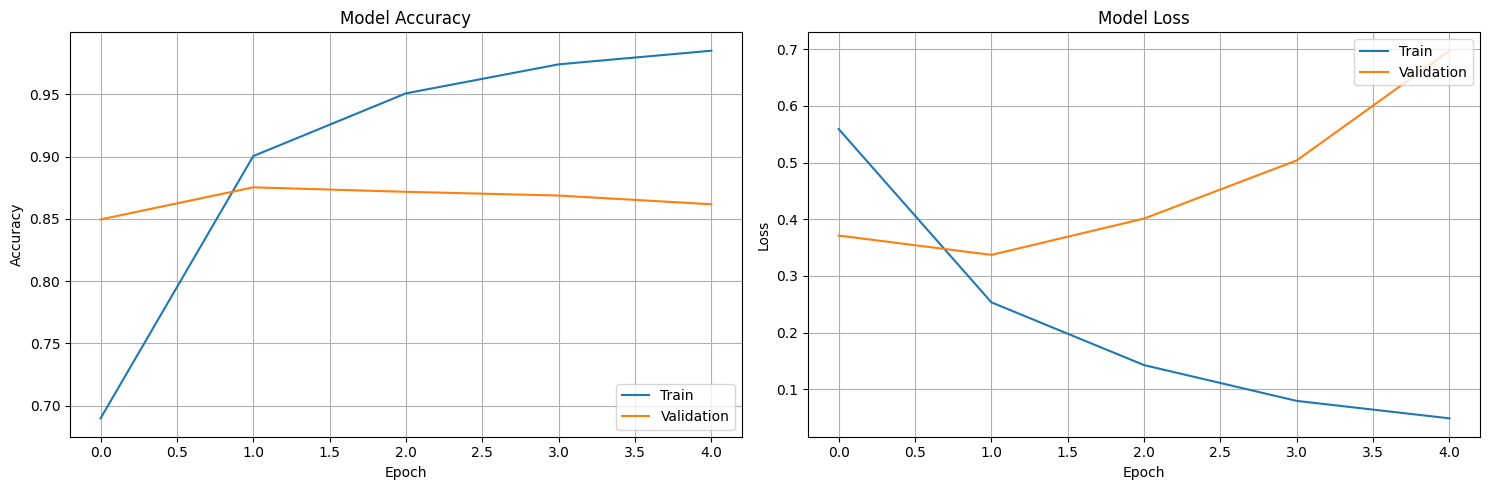

In [19]:
print("\n======== LANGKAH 2: TRAINING MODEL FINAL ========")
history = train_final_model(tuned_model)


======== LANGKAH 3: EVALUASI MODEL ========

===== Model Prediction and Evaluation =====
Evaluating on training set...
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9531 - loss: 0.1308
Training Loss: 0.1349, Training Accuracy: 0.9508

Evaluating on validation set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8780 - loss: 0.3308
Validation Loss: 0.3372, Validation Accuracy: 0.8754

Evaluating on testing set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


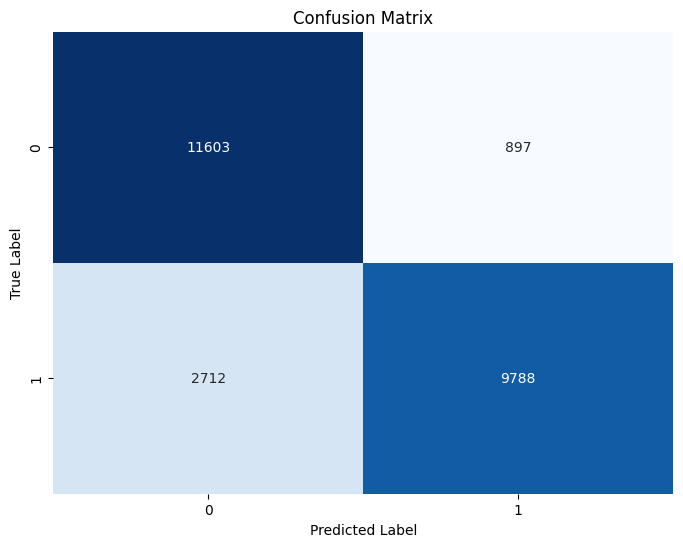

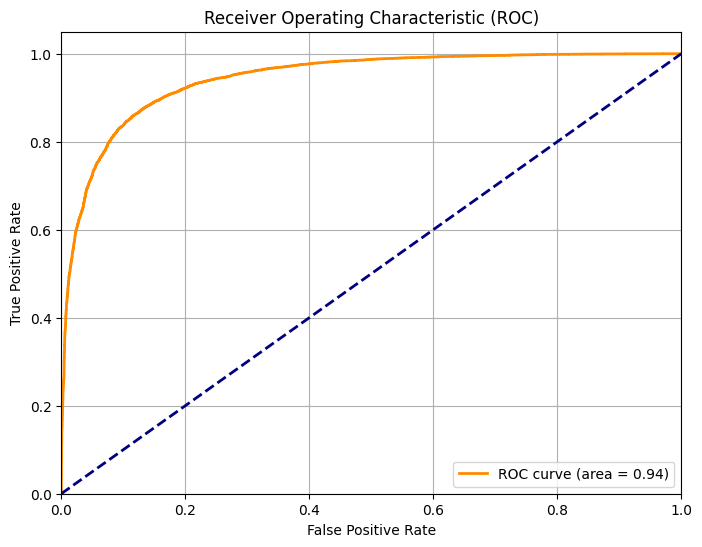


===== Model Evaluation =====
Accuracy: 0.8556
Precision: 0.9161
Recall: 0.7830
F1 Score: 0.8443
F1-Squared: 0.7129
AUC: 0.9434


In [20]:
print("\n======== LANGKAH 3: EVALUASI MODEL ========")
train_accuracy, val_accuracy, test_metrics = predict_and_evaluate(tuned_model)

In [21]:
print("\n======== HASIL AKHIR ========")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Testing Accuracy: {test_metrics['accuracy']:.4f}")


======== HASIL AKHIR ========
Training Accuracy: 0.9508
Validation Accuracy: 0.8754
Testing Accuracy: 0.8556
